In [1]:
!pip3 install textstat
!pip3 install lexicalrichness

     |████████████████████████████████| 102kB 5.2MB/s 
     |████████████████████████████████| 1.9MB 7.6MB/s 
  Created wheel for lexicalrichness: filename=lexicalrichness-0.1.3-py2.py3-none-any.whl size=8741 sha256=384ad1367466522320ba3b10477768ece33bb8077b247f1814868a373e2ab1de
  Stored in directory: /root/.cache/pip/wheels/ac/04/68/c48c4001edf1647b80b549897fd80082286ec253e343c73116
Successfully built lexicalrichness


In [1]:
%matplotlib inline
import nltk 
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')  
nltk.download('punkt')  
stop_words = set(stopwords.words('english'))

from nltk.tag import pos_tag
from nltk import word_tokenize
from collections import Counter

import textstat
from lexicalrichness import LexicalRichness
from nltk import ConditionalFreqDist
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import pandas as pd
import plotly as ply
import numpy as np
#import nltk
#nltk.download('punkt')
ply.offline.init_notebook_mode(connected=False)


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import sys

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rujunguan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/rujunguan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!python --version

Python 2.7.15


In [3]:

pd.set_option('display.max_columns', 500)
df = pd.read_csv('/content/corona_fake_3.csv')
df.loc[df['label'] == 'Fake', ['label']] = 'FAKE'
df.loc[df['label'] == 'fake', ['label']] = 'FAKE'
df.loc[df['source'] == 'facebook', ['source']] = 'Facebook'
df.text.fillna(df.title, inplace=True)

df.loc[5]['label'] = 'FAKE'
df.loc[15]['label'] = 'TRUE'
df.loc[43]['label'] = 'FAKE'
df.loc[131]['label'] = 'TRUE'
df.loc[242]['label'] = 'FAKE'

df = df.sample(frac=1).reset_index(drop=True)
df.title.fillna('missing', inplace=True)
df.source.fillna('missing', inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: '/content/corona_fake_3.csv'

In [ ]:
df['label'].unique()

Count the number of capital letters in each title.
Compute the percentage of capital letters in each article body

In [266]:
df['title_num_uppercase'] = df['title'].str.count(r'[A-Z]')
df['text_num_uppercase'] = df['text'].str.count(r'[A-Z]')
df['text_len'] = df['text'].str.len()
df['text_pct_uppercase'] = df.text_num_uppercase.div(df.text_len)

x1 = df.loc[df['label']=='TRUE']['title_num_uppercase']
x2 = df.loc[df['label'] == 'FAKE']['title_num_uppercase']
group_labels = ['TRUE', 'FAKE']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']


fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Distribution of Uppercase in title', template="plotly_white")
fig.show(renderer="colab")
#ply.offline.iplot(fig)

In [267]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Capital Letter in title', template="plotly_white")
fig.show(renderer="colab")

On average, fake news have way more words that appear in capital letters in the title.
Count the number of stop words in each title. Compute the percentage of stop words in each article body rather than simply counting the number, because the length of the articles are very different.

In [268]:
df['title_num_stop_words'] = df['title'].str.split().apply(lambda x: len(set(x) & stop_words))
df['text_num_stop_words'] = df['text'].str.split().apply(lambda x: len(set(x) & stop_words))
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['text_pct_stop_words'] = df['text_num_stop_words'] / df['text_word_count']

x1 = df.loc[df['label']=='TRUE']['title_num_stop_words']
x2 = df.loc[df['label'] == 'FAKE']['title_num_stop_words']
group_labels = ['TRUE', 'FAKE']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Distribution of Stop Words in title', template="plotly_white")
fig.show(renderer="colab")

In [269]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Stop Words in title', template="plotly_white")
fig.show(renderer="colab")

Fake news titles have fewer stop-words than those of real news.
Count number of proper nouns (NNP) in each title.

In [11]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [270]:
df.drop(['text_num_uppercase', 'text_len', 'text_num_stop_words', 'text_word_count'], axis=1, inplace=True)

df['token'] = df.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)
df['pos_tags'] = df.apply(lambda row: nltk.pos_tag(row['token']), axis=1)

tag_count_df = pd.DataFrame(df['pos_tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())
df = pd.concat([df, tag_count_df], axis=1).fillna(0).drop(['pos_tags', 'token'], axis=1)

df = df[['title', 'text', 'source', 'label', 'title_num_uppercase', 'text_pct_uppercase', 'title_num_stop_words', 'text_pct_stop_words', 'NNP']].rename(columns={'NNP': 'NNP_title'})

x1 = df.loc[df['label']=='TRUE']['NNP_title']
x2 = df.loc[df['label'] == 'FAKE']['NNP_title']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Number of Proper nouns in title', template="plotly_white")
fig.show(renderer="colab")

In [271]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Proper nouns in title', template="plotly_white")
fig.show(renderer="colab")

 compute many content based features on the article bodies. They are:
Use part-of-speech tagger and keep a count of how many times each tag appears in the article.

In [272]:
df['token'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
df['pos_tags'] = df.apply(lambda row: nltk.pos_tag(row['token']), axis=1)

tag_count_df = pd.DataFrame(df['pos_tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())

df = pd.concat([df, tag_count_df], axis=1).fillna(0).drop(['pos_tags', 'token'], axis=1)

number of negation and interrogatives in the title and text

In [273]:
df['num_negation'] = df['text'].str.lower().str.count("no|not|never|none|nothing|nobody|neither|nowhere|hardly|scarcely|barely|doesn’t|isn’t|wasn’t|shouldn’t|wouldn’t|couldn’t|won’t|can't|don't")

df['num_interrogatives_title'] = df['title'].str.lower().str.count("what|who|when|where|which|why|how")
df['num_interrogatives_text'] = df['text'].str.lower().str.count("what|who|when|where|which|why|how")


textstat to calculate statistics from text to determine readability, complexity and grade level of any article.
https://pypi.org/project/textstat/ 

In [274]:
reading_ease = []
for doc in df['text']:
    reading_ease.append(textstat.flesch_reading_ease(doc))
    
smog = []
for doc in df['text']:
    smog.append(textstat.smog_index(doc))
    
kincaid_grade = []
for doc in df['text']:
    kincaid_grade.append(textstat.flesch_kincaid_grade(doc))
    
liau_index = []
for doc in df['text']:
    liau_index.append(textstat.coleman_liau_index(doc))
    
readability_index = []
for doc in df['text']:
    readability_index.append(textstat.automated_readability_index(doc))

readability_score = []
for doc in df['text']:
    readability_score.append(textstat.dale_chall_readability_score(doc))
    
difficult_words = []
for doc in df['text']:
    difficult_words.append(textstat.difficult_words(doc))

write_formula = []
for doc in df['text']:
    write_formula.append(textstat.linsear_write_formula(doc))

gunning_fog = []
for doc in df['text']:
    gunning_fog.append(textstat.gunning_fog(doc))

text_standard = []
for doc in df['text']:
    text_standard.append(textstat.text_standard(doc))
    
df['flesch_reading_ease'] = reading_ease
df['smog_index'] = smog
df['flesch_kincaid_grade'] = kincaid_grade
df['automated_readability_index'] = readability_index
df['dale_chall_readability_score'] = readability_score
df['difficult_words'] = difficult_words
df['linsear_write_formula'] = write_formula
df['gunning_fog'] = gunning_fog
df['text_standard'] = text_standard
# readability, complexity and grade level of any article

In [275]:
ttr = []
for doc in df['text']:
    lex = LexicalRichness(doc)
    ttr.append(lex.ttr)

df['ttr'] = ttr  # total number of unique words (types) divided by the total number of words (tokens)

Number of power words, casual words, tentative words, emotion words in the article body.

In [276]:
df['num_powerWords_text'] = df['text'].str.lower().str.count('improve|trust|immediately|discover|profit|learn|know|understand|powerful|best|win|more|bonus|exclusive|extra|you|free|health|guarantee|new|proven|safety|money|now|today|results|protect|help|easy|amazing|latest|extraordinary|how to|worst|ultimate|hot|first|big|anniversary|premiere|basic|complete|save|plus|create')
df['num_casualWords_text'] = df['text'].str.lower().str.count('make|because|how|why|change|use|since|reason|therefore|result')
df['num_tentativeWords_text'] = df['text'].str.lower().str.count('may|might|can|could|possibly|probably|it is likely|it is unlikely|it is possible|it is probable|tends to|appears to|suggests that|seems to')
df['num_emotionWords_text'] = df['text'].str.lower().str.count('ordeal|outrageous|provoke|repulsive|scandal|severe|shameful|shocking|terrible|tragic|unreliable|unstable|wicked|aggravate|agony|appalled|atrocious|corruption|damage|disastrous|disgusted|dreadful|eliminate|harmful|harsh|inconsiderate|enraged|offensive|aggressive|frustrated|controlling|resentful|anger|sad|fear|malicious|infuriated|critical|violent|vindictive|furious|contrary|condemning|sarcastic|poisonous|jealous|retaliating|desperate|alienated|unjustified|violated')

Capital Letters in Article Body

In [277]:
x1 = df.loc[df['label']=='TRUE']['text_pct_uppercase']
x2 = df.loc[df['label'] == 'FAKE']['text_pct_uppercase']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Percentage of Capital Letter in Article body', template="plotly_white")
fig.show(renderer="colab")

In [278]:
x1 = df.loc[df['label']=='TRUE']['text_pct_stop_words']
x2 = df.loc[df['label'] == 'FAKE']['text_pct_stop_words']
print(x1)
group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Percentage of Stop Words in Text', template="plotly_white")
fig.show(renderer="colab")

0       0.160622
1       0.067620
3       0.231884
4       0.246154
6       0.237500
          ...   
1421    0.225806
1424    0.183007
1432    0.266667
1433    0.085069
1436    0.140496
Name: text_pct_stop_words, Length: 714, dtype: float64


In [135]:
x1 = df.loc[df['label']=='TRUE']['NNP']
x2 = df.loc[df['label'] == 'FAKE']['NNP']
group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Number of Proper noun in Article Body', template="plotly_white")
fig.show(renderer="colab")

In [279]:
x1 = df.loc[df['label']=='TRUE']['num_negation']
x2 = df.loc[df['label'] == 'FAKE']['num_negation']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Number of Negations in Text', template="plotly_white")
fig.show(renderer="colab")


In [280]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.update_layout(title_text='Box plot of Brackets in Article Bodies', template="plotly_white")
fig.show(renderer="colab")

In [281]:
x1 = df.loc[df['label']=='TRUE']['ttr']
x2 = df.loc[df['label'] == 'FAKE']['ttr']

group_labels = ['TRUE', 'FAKE']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Type-token ratio in Article Bodies', template="plotly_white")
fig.show(renderer="colab")

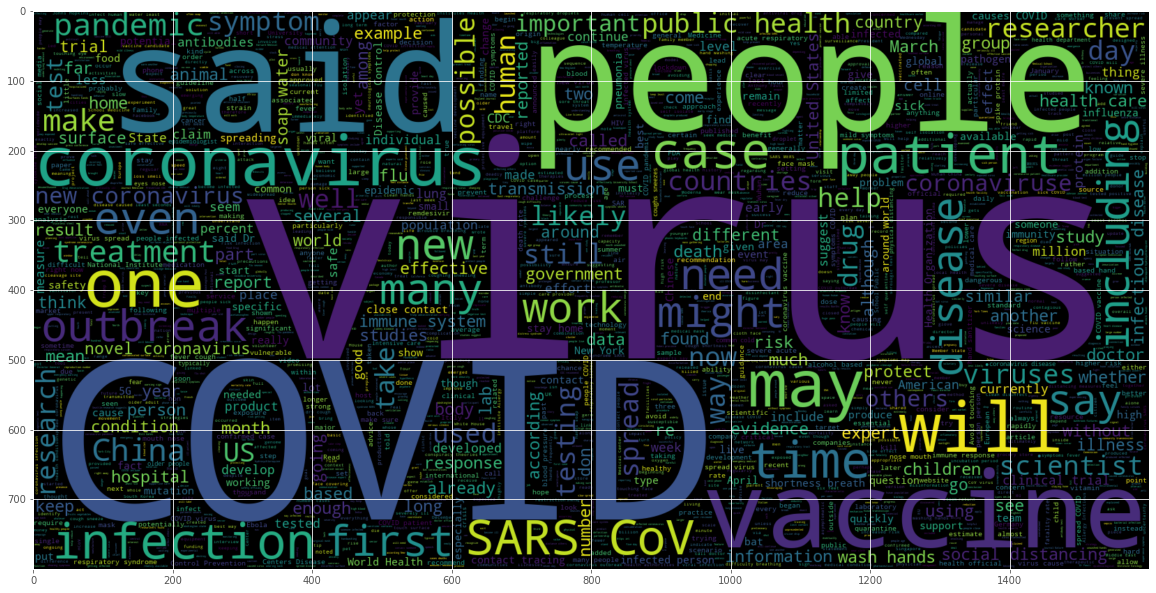

In [169]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 'TRUE'].text))
plt.imshow(wc , interpolation = 'bilinear')

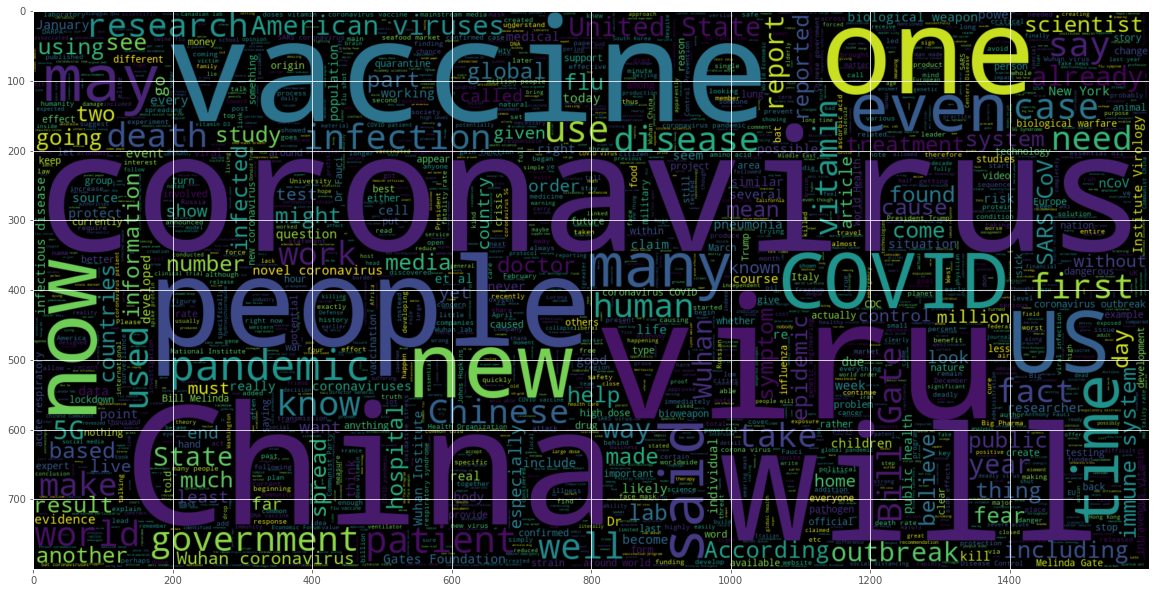

In [170]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 'FAKE'].text))
plt.imshow(wc , interpolation = 'bilinear')

The Classification Model
Support Vector Machine (SVM) model with a linear kernel  10-fold cross-validation to prevent overfitting.


In [140]:
X, y = df.drop(['title', 'text', 'source', 'label', 'text_standard'], axis = 1), df['label']
scaler = StandardScaler()
scaler.fit(X)
X_ = scaler.transform(X)

svc=LinearSVC(dual=False)
scores = cross_val_score(svc, X_, y, cv=10, scoring='accuracy')
print(scores)

0       TRUE
1       TRUE
2       FAKE
3       FAKE
4       FAKE
        ... 
1434    TRUE
1435    TRUE
1436    FAKE
1437    FAKE
1438    FAKE
Name: label, Length: 1439, dtype: object
[0.90277778 0.82638889 0.84027778 0.77777778 0.85416667 0.88194444
 0.79861111 0.88888889 0.92361111 0.87412587]


In [141]:
print(scores.mean())

0.856857031857032


In [142]:
from xgboost import XGBRegressor
from sklearn.linear_model import BayesianRidge, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
#from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder


In [143]:
print(df['label'].value_counts())
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)


FAKE    725
TRUE    714
Name: label, dtype: int64


In [163]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=42)

In [145]:
X_train

title_num_uppercase  text_pct_uppercase  title_num_stop_words  \
96                      1            0.020642                     2   
1165                    2            0.012797                     5   
439                     6            0.021405                     1   
1103                    4            0.034330                     2   
410                     1            0.024160                     1   
...                   ...                 ...                   ...   
1095                    4            0.030949                     2   
1130                    1            0.004193                     4   
1294                    7            0.013884                     2   
860                     1            0.016277                     2   
1126                    7            0.049061                     0   

      text_pct_stop_words  NNP_title    NNP   VBZ     DT     JJ     NN   WDT  \
96               0.187500        0.0    0.0   2.0    3.0   14.0   12.0   0.0   
1165             0.058918        0.0   57.0  44.0  118.0  149.0  221.0  17.0   
439              0.167832        1.0   10.0   6.0   25.0   30.0   42.0   6.0   
1103             0.195946        4.0   24.0   5.0   13.0   13.0   27.0   0.0   
410              0.145985        0.0    6.0   6.0    9.0   16.0   20.0   0.0   
...                   ...        ...    ...   ...    ...    ...    ...   ...   
1095             0.061375        4.0   73.0  38.0  148.0  104.0  187.0   1.0   
1130             0.338028        0.0    1.0   2.0    6.0    8.0   11.0   0.0   
1294             0.054657        5.0   66.0  32.0  160.0  132.0  219.0   9.0   
860              0.105263        0.0   13.0  13.0   39.0   48.0   56.0   8.0   
1126             0.079840        4.0  111.0  10.0   43.0   48.0   73.0   1.0   

        MD    VB   NNS     .    RB     ,   EX     IN   VBG   VBN  JJS    WP  \
96     1.0   2.0   6.0   3.0   1.0   1.0  0.0   10.0   0.0   0.0  0.0   1.0   
1165  16.0  63.0  98.0  40.0  65.0  58.0  3.0  149.0  37.0  36.0  1.0  11.0   
439    7.0  15.0  34.0  12.0  10.0  24.0  1.0   33.0   6.0  13.0  1.0   1.0   
1103   2.0   2.0  10.0   6.0   5.0   5.0  0.0   21.0   4.0   6.0  0.0   4.0   
410    0.0   5.0  15.0   7.0   4.0  14.0  1.0   15.0   1.0   6.0  1.0   0.0   
...    ...   ...   ...   ...   ...   ...  ...    ...   ...   ...  ...   ...   
1095  15.0  34.0  77.0  64.0  65.0  69.0  6.0  160.0  36.0  24.0  3.0   4.0   
1130   1.0   2.0   9.0   2.0   2.0   6.0  0.0    8.0  10.0   0.0  1.0   0.0   
1294  14.0  59.0  72.0  23.0  65.0  37.0  0.0  190.0  43.0  50.0  3.0  10.0   
860   11.0  25.0  56.0  11.0  21.0  29.0  2.0   62.0   8.0  10.0  0.0   0.0   
1126   1.0   8.0  27.0  16.0  12.0  21.0  0.0   70.0  13.0  14.0  2.0   4.0   

       VBP    CC  PRP$   PRP    TO    CD   VBD    :   RP   FW  RBR    (    )  \
96     1.0   3.0   0.0   0.0   2.0   7.0   1.0  1.0  0.0  0.0  0.0  1.0  1.0   
1165  39.0  52.0  12.0  27.0  48.0   4.0  21.0  5.0  0.0  0.0  3.0  1.0  1.0   
439   17.0  11.0   3.0   3.0   6.0   0.0   0.0  0.0  0.0  0.0  0.0  2.0  2.0   
1103   7.0   5.0   1.0   7.0   2.0   1.0   8.0  0.0  0.0  0.0  0.0  0.0  0.0   
410    4.0   5.0   1.0   2.0   5.0  13.0   0.0  4.0  0.0  0.0  0.0  3.0  3.0   
...    ...   ...   ...   ...   ...   ...   ...  ...  ...  ...  ...  ...  ...   
1095  35.0  45.0  12.0  39.0  35.0  22.0  30.0  1.0  4.0  0.0  2.0  6.0  6.0   
1130   1.0   3.0   2.0   2.0   2.0   0.0   0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1294  35.0  43.0  12.0  25.0  46.0  10.0  19.0  5.0  1.0  0.0  1.0  1.0  1.0   
860   12.0  17.0   1.0   5.0  15.0  22.0   9.0  1.0  0.0  0.0  2.0  0.0  0.0   
1126   3.0  16.0   2.0   3.0  11.0  15.0  30.0  0.0  1.0  0.0  0.0  2.0  2.0   

       JJR   WRB   ``   ''  NNPS   UH  WP$    $  PDT  POS  RBS    #  SYM  \
96     0.0   0.0  0.0  0.0   0.0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0   
1165   8.0   5.0  0.0  0.0   2.0  0.0  1.0  0.0  1.0  0.0  3.0  0.0  0.0   
439    6.0   1.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  

In [146]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

In [147]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]


for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    scores = cross_val_score(clf, X_test, y_test, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
  #  log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
   # log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 77.5463%
Log Loss: 2.2199109695554
SVC
****Results****
Accuracy: 51.8519%
Log Loss: 0.6796729539762177
NuSVC
****Results****
Accuracy: 83.7963%
Log Loss: 0.36415800856149944
DecisionTreeClassifier
****Results****
Accuracy: 80.0926%
Log Loss: 6.8757749304683315
RandomForestClassifier
****Results****
Accuracy: 88.4259%
Log Loss: 0.3130516904376301
AdaBoostClassifier
****Results****
Accuracy: 87.5000%
Log Loss: 0.652864693670738
GradientBoostingClassifier
****Results****
Accuracy: 87.7315%
Log Loss: 0.2861037277992256
GaussianNB
****Results****
Accuracy: 60.6481%
Log Loss: 6.75610261768195
LinearDiscriminantAnalysis
****Results****
Accuracy: 85.1852%
Log Loss: 0.3441035297716968
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 68.7500%
Log Loss: 5.064054765922747


Random Forest perform best in machine learning, so we save it as .pkl

In [148]:
clf4 = RandomForestClassifier(min_samples_split=7, verbose=True)
clf4.fit(X_train, y_train)
importances = clf4.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf4.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Feature ranking:
1. feature 4 (0.113558)
2. feature 0 (0.093076)
3. feature 50 (0.082308)
4. feature 2 (0.074320)
5. feature 5 (0.037662)
6. feature 1 (0.030379)
7. feature 57 (0.025005)
8. feature 8 (0.022280)
9. feature 13 (0.021249)
10. feature 29 (0.020541)
11. feature 24 (0.019955)
12. feature 28 (0.019310)
13. feature 60 (0.016353)
14. feature 18 (0.014997)
15. feature 7 (0.014907)
16. feature 16 (0.014810)
17. feature 52 (0.013321)
18. feature 61 (0.013234)
19. feature 54 (0.013209)
20. feature 55 (0.012685)
21. feature 11 (0.012596)
22. feature 9 (0.012571)
23. feature 14 (0.012491)
24. feature 59 (0.012427)
25. feature 53 (0.012330)
26. feature 15 (0.012298)
27. feature 63 (0.012197)
28. feature 12 (0.012113)
29. feature 58 (0.011657)
30. feature 35 (0.011594)
31. feature 23 (0.011474)
32. feature 3 (0.011156)
33. feature 6 (0.010531)
34. feature 56 (0.010392)
35. feature 30 (0.009837)
36. feature 49 (0.009334)
37. feature 26 (0.009243)
38. feature 19 (0.008941)
39. feature 34

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [150]:
X_train_new = X_train.iloc[:,[4,0,50,2,5,1]]
X_test_new = X_test.iloc[:,[4,0,50,2,5,1]]
X_test_new

NNP_title  title_num_uppercase  num_interrogatives_title  \
168         0.0                    0                         0   
605         0.0                    0                         0   
548         1.0                    7                         1   
65          1.0                    3                         0   
628         0.0                    1                         1   
...         ...                  ...                       ...   
591         0.0                    0                         0   
979         5.0                    6                         0   
1189       12.0                   74                         0   
438         0.0                    3                         0   
672         1.0                    2                         0   

      title_num_stop_words    NNP  text_pct_uppercase  
168                      0    0.0            0.018519  
605                      0   28.0            0.046953  
548                      5   34.0            0.022649  
65                       3    2.0            0.007353  
628                      8    4.0            0.007767  
...                    ...    ...                 ...  
591                      0    2.0            0.024390  
979                      0  351.0            0.032882  
1189                     0    8.0            0.036765  
438                      1    1.0            0.022222  
672                      2    4.0            0.077519  

[432 rows x 6 columns]

In [153]:
classifiers = [
    RandomForestClassifier()
]


for clf in classifiers:
    clf.fit(X_train_new, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test_new)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test_new)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))

import joblib

joblib.dump(clf, '/content/random_forest.pkl', compress=9)

RandomForestClassifier
****Results****
Accuracy: 85.4167%
Log Loss: 0.3214508857850414


['/content/random_forest.pkl']

semi_supervised training

In [154]:
from sklearn.semi_supervised import LabelSpreading

In [155]:
n_total_samples = len(y)
n_labeled_points = 500

indices = np.arange(n_total_samples)

unlabeled_set = indices[n_labeled_points:]

# #############################################################################
# Shuffle everything around
y_train = np.copy(y)
y_train[unlabeled_set] = -1
print(y_train)
#y_train = np.copy(y_train)
#y_train[unlabeled_set] = -1
# #############################################################################
# Learn with LabelSpreading
lp_model = LabelSpreading(gamma=.25, max_iter=20)
lp_model.fit(X, y_train)
predicted_labels = lp_model.transduction_[unlabeled_set]
true_labels = y[unlabeled_set]




[ 1  1  0 ... -1 -1 -1]


/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning:

invalid value encountered in true_divide



In [156]:
predicted_labels


array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [157]:
acc = accuracy_score(true_labels, predicted_labels)
print("Accuracy: {:.4%}".format(acc))

Accuracy: 73.9084%


RNN neural network training (1 layer)

In [158]:
from keras.models import Sequential
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [159]:
model.compile(loss='binary_crossentropy', 
           optimizer='adam', 
           metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                660       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 671
Trainable params: 671
Non-trainable params: 0
_________________________________________________________________


In [164]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1007, 65)
(1007,)
(432, 65)
(432,)


In [165]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

In [166]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9315
Testing Accuracy:  0.8657


In [167]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#history_dict = history.history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

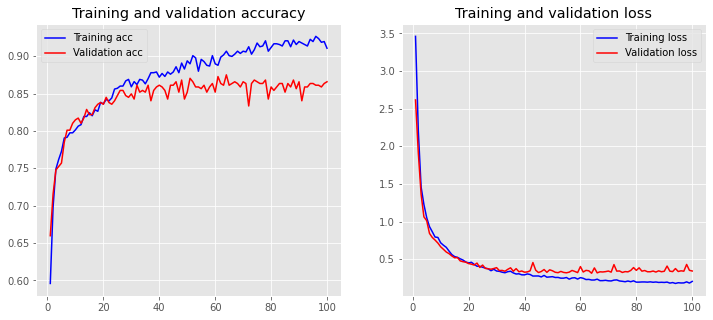

In [168]:
plot_history(history)

##Method II

In [178]:
import re
import string
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [175]:
def clean_text(txt):
    """""
    cleans the input text in the following steps
    1- replace contractions
    2- removing punctuation
    3- spliting into words
    4- removing stopwords
    5- removing leftover punctuations
    """""
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)
    
    #remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)
    
    # split into words
    words = word_tokenize(txt)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]
    
    cleaned_text = ' '.join(words)
    return cleaned_text
    
df['data_cleaned'] = df['title'].apply(lambda txt: clean_text(txt))
df['data_cleaned']

0       Can eating garlic help prevent infection new c...
1       You recover coronavirus disease COVID Catching...
2                                                 missing
3       New evidence Coronavirus bioweapon might Chine...
4       Official Pentagon conserves dangerous pathogen...
                              ...                        
1434           What I I think I child may COVID infection
1435         New name disease caused virus outbreak COVID
1436                     SOLVING THE WUHANG COVID MYSTERY
1437                                              missing
1438    Bobby Kennedy Jr Claims Dr Fauci Gates Foundat...
Name: data_cleaned, Length: 1439, dtype: object

In [188]:

labelencoder = LabelEncoder()
df['label'] = labelencoder.fit_transform(df['label'])
xtrain, xtest, ytrain, ytest = train_test_split(df['data_cleaned'], df['label'], shuffle=True, test_size=0.2)
# find the length of the largest sentence in training data



max_len = xtrain.apply(lambda x: len(x)).max()
print(f'Max number of words in a text in training data: {max_len}')

Max number of words in a text in training data: 199


In [180]:
max_words = 10000
tokenizer = Tokenizer(num_words = max_words)
# create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(xtrain)
# generate the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)

# pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index

print('text example:', xtrain[0])
print('sequence of indices(before padding):', xtrain_seq[0])
print('sequence of indices(after padding):', xtrain_pad[0])

text example: Can eating garlic help prevent infection new coronavirus
sequence of indices(before padding): [6]
sequence of indices(after padding): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 6]


https://nlp.stanford.edu/projects/glove/

In [183]:
%%time
embedding_vectors = {}
# with open('/kaggle/input/glove6b100d/glove.6B.100d.txt','r',encoding='utf-8') as file:
with open('/content/glove.6B.100d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}") 

Size of vocabulary in GloVe: 400000
CPU times: user 12.6 s, sys: 388 ms, total: 13 s
Wall time: 13 s


In [184]:
emb_dim = 100
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')

Some out of valubulary words: ['covid', 'ncov', 'sarscov', 'hydroxychloroquine', 'selfquarantine']


In [185]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,117,377
Trainable params: 117,377
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [189]:
ytrain

972     0
430     1
778     1
1068    0
1014    0
       ..
350     1
206     1
913     0
151     0
1125    1
Name: label, Length: 1151, dtype: int64

In [190]:
batch_size = 256
epochs  = 10
history = lstm_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

Epoch 1/10
5/5 [==============================] - 6s 948ms/step - loss: 0.7011 - accuracy: 0.4970 - val_loss: 0.7025 - val_accuracy: 0.4792
Epoch 2/10
5/5 [==============================] - 4s 838ms/step - loss: 0.6917 - accuracy: 0.5100 - val_loss: 0.6940 - val_accuracy: 0.5451
Epoch 3/10
5/5 [==============================] - 4s 835ms/step - loss: 0.6864 - accuracy: 0.5578 - val_loss: 0.6965 - val_accuracy: 0.4514
Epoch 4/10
5/5 [==============================] - 4s 842ms/step - loss: 0.6764 - accuracy: 0.5708 - val_loss: 0.7065 - val_accuracy: 0.5000
Epoch 5/10
5/5 [==============================] - 4s 832ms/step - loss: 0.6787 - accuracy: 0.5639 - val_loss: 0.7005 - val_accuracy: 0.4583
Epoch 6/10
5/5 [==============================] - 4s 841ms/step - loss: 0.6707 - accuracy: 0.5882 - val_loss: 0.6977 - val_accuracy: 0.5000
Epoch 7/10
5/5 [==============================] - 4s 815ms/step - loss: 0.6685 - accuracy: 0.5812 - val_loss: 0.6986 - val_accuracy: 0.5069
Epoch 8/10
5/5 [====

Text(0.5, 1.0, 'Accuracy')

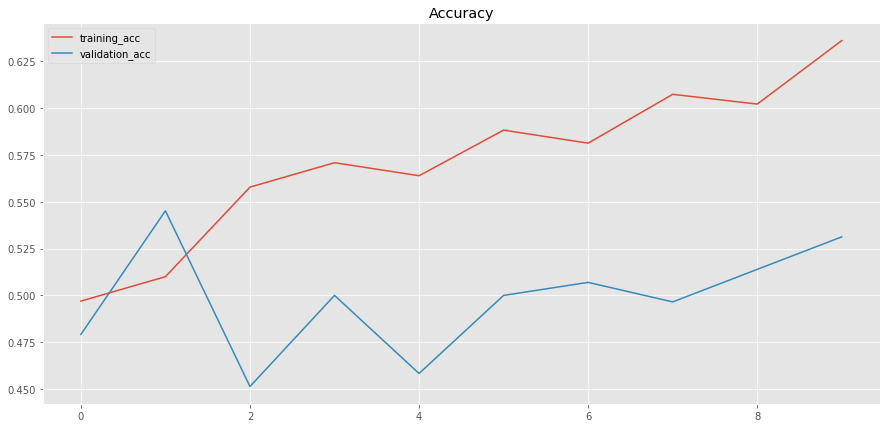

In [191]:
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [192]:
train_lstm_results = lstm_model.evaluate(xtrain_pad, np.asarray(ytrain), verbose=0, batch_size=256)
test_lstm_results = lstm_model.evaluate(xtest_pad, np.asarray(ytest), verbose=0, batch_size=256)
print(f'Train accuracy: {train_lstm_results[1]*100:0.2f}')
print(f'Test accuracy: {test_lstm_results[1]*100:0.2f}')

Train accuracy: 64.21
Test accuracy: 53.12


In [193]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()
gru_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,088,449
Trainable params: 88,449
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [194]:
batch_size = 256
epochs  = 10
history = gru_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

Epoch 1/10
5/5 [==============================] - 6s 873ms/step - loss: 0.7071 - accuracy: 0.4963 - val_loss: 0.7073 - val_accuracy: 0.5139
Epoch 2/10
5/5 [==============================] - 4s 721ms/step - loss: 0.6970 - accuracy: 0.5252 - val_loss: 0.6937 - val_accuracy: 0.5069
Epoch 3/10
5/5 [==============================] - 4s 726ms/step - loss: 0.6917 - accuracy: 0.5293 - val_loss: 0.6963 - val_accuracy: 0.5347
Epoch 4/10
5/5 [==============================] - 3s 691ms/step - loss: 0.6835 - accuracy: 0.5462 - val_loss: 0.7057 - val_accuracy: 0.5243
Epoch 5/10
5/5 [==============================] - 3s 690ms/step - loss: 0.6630 - accuracy: 0.5938 - val_loss: 0.6954 - val_accuracy: 0.5243
Epoch 6/10
5/5 [==============================] - 4s 705ms/step - loss: 0.6686 - accuracy: 0.5922 - val_loss: 0.6937 - val_accuracy: 0.5521
Epoch 7/10
5/5 [==============================] - 4s 705ms/step - loss: 0.6685 - accuracy: 0.5984 - val_loss: 0.6943 - val_accuracy: 0.5417
Epoch 8/10
5/5 [====

Text(0.5, 1.0, 'Accuracy')

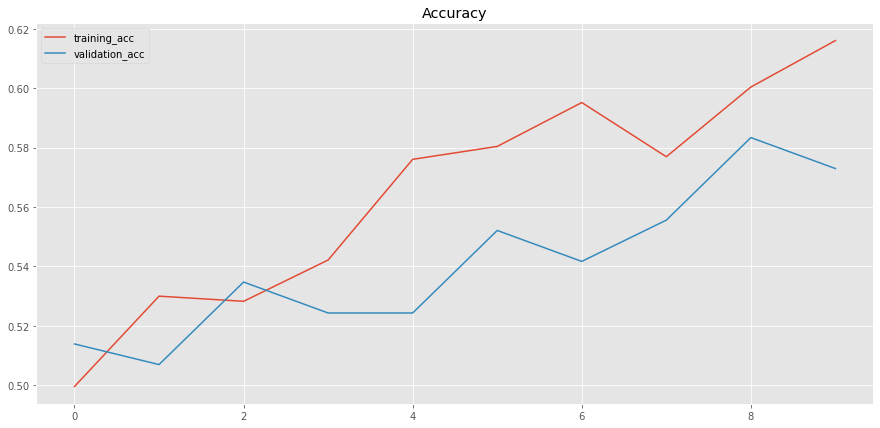

In [195]:
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [196]:
train_gru_results = gru_model.evaluate(xtrain_pad, np.asarray(ytrain), verbose=0, batch_size=256)
test_gru_results = gru_model.evaluate(xtest_pad, np.asarray(ytest), verbose=0, batch_size=256)
print(f'Train accuracy: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy: {test_gru_results[1]*100:0.2f}')

Train accuracy: 65.16
Test accuracy: 57.29


In [198]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(vocab_len+100, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 128)         1292800   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,490,561
Trainable params: 1,490,561
Non-trainable params: 0
_________________________________________________________________


In [199]:
adam = keras.optimizers.Adam(lr = 0.000000001)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history=model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

Epoch 1/10
5/5 [==============================] - 18s 3s/step - loss: 0.6933 - accuracy: 0.5117 - val_loss: 0.6933 - val_accuracy: 0.4931
Epoch 2/10
5/5 [==============================] - 11s 2s/step - loss: 0.6905 - accuracy: 0.5590 - val_loss: 0.6917 - val_accuracy: 0.5208
Epoch 3/10
5/5 [==============================] - 11s 2s/step - loss: 0.6866 - accuracy: 0.5722 - val_loss: 0.6936 - val_accuracy: 0.5104
Epoch 4/10
5/5 [==============================] - 11s 2s/step - loss: 0.6732 - accuracy: 0.6000 - val_loss: 0.6951 - val_accuracy: 0.5035
Epoch 5/10
5/5 [==============================] - 11s 2s/step - loss: 0.6406 - accuracy: 0.7017 - val_loss: 0.7232 - val_accuracy: 0.5208
Epoch 6/10
5/5 [==============================] - 11s 2s/step - loss: 0.5486 - accuracy: 0.7381 - val_loss: 0.8242 - val_accuracy: 0.4757
Epoch 7/10
5/5 [==============================] - 11s 2s/step - loss: 0.4744 - accuracy: 0.7984 - val_loss: 1.0368 - val_accuracy: 0.4792
Epoch 8/10
5/5 [==================

Text(0.5, 1.0, 'Accuracy')

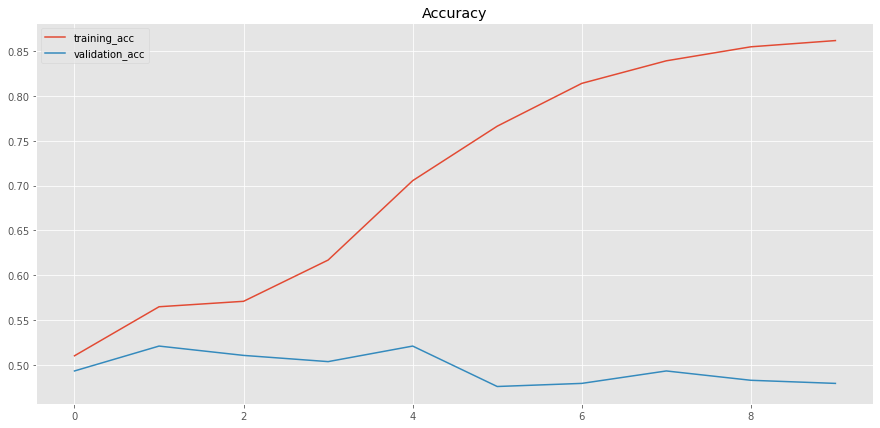

In [206]:
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [207]:
from itertools import chain

import torch
import torch.nn as nn
import torch.nn.functional as F

In [282]:

df

title  \
0     What is the difference between isolation and q...   
1     Who is most likely to be infected with SARS-Co...   
2     Big Pharma Beware: Dr. Montagnier Shines New L...   
3     What temperature kills the virus that causes C...   
4     What is the risk of getting COVID-19 from pack...   
...                                                 ...   
1434                                            missing   
1435  The coronavirus has been 'released' by China [...   
1436  What should I do if I missed out on my educati...   
1437  Did coronavirus originate in Chinese governmen...   
1438  First volunteer in UK coronavirus vaccine tria...   

                                                   text  \
0     Both isolation and quarantine are methods of p...   
1     Despite the daily updates on number of cases, ...   
2     This April 16th, Dr. Luc Montagnier became a h...   
3     Generally coronaviruses survive for shorter pe...   
4     A recent study published by The New England Jo...   
...                                                 ...   
1434  This is to inform us all that the pH for coron...   
1435   the coronavirus SARS-CoV-2, which is responsi...   
1436  Your school or place where you are studying ar...   
1437  Chinese scientists believe the deadly coronavi...   
1438  Elisa Granato, the first volunteer who availed...   

                                                 source label  \
0     https://www.who.int/news-room/q-a-detail/q-a-c...  TRUE   
1                            https://www.thelancet.com/  TRUE   
2                    https://www.strategic-culture.org/  FAKE   
3                                  https://www.cdc.gov/  TRUE   
4                            https://www.ecdc.europa.eu  TRUE   
...                                                 ...   ...   
1434                                           Facebook  FAKE   
1435                          http://MyNaCl.blogspot.in  FAKE   
1436  https://www.who.int/emergencies/diseases/novel...  TRUE   
1437  https://www.dailymail.co.uk/news/article-80096...  FAKE   
1438                                           Facebook  FAKE   

      title_num_uppercase  text_pct_uppercase  title_num_stop_words  \
0                       1            0.031278                     4   
1                       7            0.022649                     5   
2                      16            0.022903                     3   
3                       6            0.015217                     2   
4                       6            0.050000                     5   
...                   ...                 ...                   ...   
1434                    0            0.123050                     0   
1435                    3            0.040462                     6   
1436                    8            0.024552                     8   
1437                    4            0.038420                     3   
1438                    3            0.020265                     2   

      text_pct_stop_words  NNP_title     DT     NN    CC   VBP    NNS     IN  \
0                0.160622        0.0   15.0   30.0  10.0   9.0   14.0   35.0   
1                0.067620        1.0   55.0  132.0  33.0  15.0   90.0  124.0   
2                0.040541        9.0  251.0  382.0  65.0  43.0  159.0  331.0   
3                0.231884        1.0    7.0   15.0   4.0   4.0    7.0   12.0   
4                0.246154        1.0    5.0   10.0   2.0   1.0    5.0   10.0   
...                   ...        ...    ...    ...   ...   ...    ...    ...   
1434             0.183486        0.0   10.0   14.0   1.0   4.0    3.0    8.0   
1435             0.423077        2.0    4.0    4.0   0.0   0.0    1.0    4.0   
1436             0.140496        1.0   10.0   38.0  12.0  11.0   30.0   23.0   
1437             0.106904        2.0   55.0   71.0  13.0   5.0   31.0   64.0   
1438             0.176744        2.0   33.0   31.0   4.0   9.0   17.0   28.0   

       VBG    NNP     .   VBZ   VBN  

In [284]:
X, y = df.drop(['title', 'text', 'source', 'label','text_standard'], axis = 1), df['label']
le = LabelEncoder()
y = le.fit_transform(y)
y = y.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [286]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [293]:
from torch.utils.data import Dataset, DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)
print(train_data)

In [298]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 109.
        self.layer_1 = nn.Linear(65, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [299]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import torch.optim as optim
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)




cpu
binaryClassification(
  (layer_1): Linear(in_features=65, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [300]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [302]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
       # print(y_pred)
       # print(y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.14575 | Acc: 93.312
Epoch 002: | Loss: 0.12423 | Acc: 94.250
Epoch 003: | Loss: 0.10869 | Acc: 94.500
Epoch 004: | Loss: 0.08919 | Acc: 97.188
Epoch 005: | Loss: 0.11282 | Acc: 95.375
Epoch 006: | Loss: 0.13124 | Acc: 94.125
Epoch 007: | Loss: 0.16795 | Acc: 92.750
Epoch 008: | Loss: 0.15519 | Acc: 94.375
Epoch 009: | Loss: 0.12458 | Acc: 95.812
Epoch 010: | Loss: 0.12615 | Acc: 95.062
Epoch 011: | Loss: 0.11290 | Acc: 95.562
Epoch 012: | Loss: 0.10809 | Acc: 95.625
Epoch 013: | Loss: 0.10473 | Acc: 95.688
Epoch 014: | Loss: 0.24673 | Acc: 93.312
Epoch 015: | Loss: 0.13664 | Acc: 94.000
Epoch 016: | Loss: 0.09105 | Acc: 96.938
Epoch 017: | Loss: 0.12094 | Acc: 93.938
Epoch 018: | Loss: 0.10389 | Acc: 96.500
Epoch 019: | Loss: 0.22771 | Acc: 92.812
Epoch 020: | Loss: 0.18007 | Acc: 92.062
Epoch 021: | Loss: 0.18365 | Acc: 92.000
Epoch 022: | Loss: 0.14021 | Acc: 95.062
Epoch 023: | Loss: 0.15534 | Acc: 92.375
Epoch 024: | Loss: 0.17419 | Acc: 92.375
Epoch 025: | Los

In [304]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       247
           1       0.83      0.87      0.85       228

    accuracy                           0.85       475
   macro avg       0.85      0.85      0.85       475
weighted avg       0.85      0.85      0.85       475

